Importando funções necessárias

In [77]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from scipy import stats
import matplotlib.pyplot as plot
import seaborn as sns
import pandas as pd
import numpy as np

Função para adicionar as medidas na tabela de acurácia

In [78]:
def add_result_measure(met, df, scores):
    inf, sup = stats.norm.interval(0.95, loc=scores.mean(), 
                               scale=scores.std()/np.sqrt(len(scores)))
    new_row = pd.DataFrame([[met, round(scores.mean(), 2), round(scores.std(), 2), round(inf, 2), round(sup, 2)]],
                            columns=['Método', 'Média', 'Desvio Padrão', 'Limite Inferior', 'Limite Superior'])
    df = pd.concat([df, new_row])
    return df

Função que cria a tabela de p-valores

In [79]:
def table_htest(list_scores):
    from scipy.stats import ttest_rel, wilcoxon
    list_estimators = ['ZR', 'NBG', 'KMC','KNN', 'AD']
    table_htest = [[0 for _ in range(len(list_estimators))] for _ in range(len(list_estimators))]

    for row in range(len(list_estimators)):
        for col in range(len(list_estimators)):
            if(row == col):
                table_htest[row][col] = list_estimators[row]
            else:
                if(col > row):
                    s,p = ttest_rel(list_scores[row],list_scores[col])
                    table_htest[row][col] = round(p, 3)
                else:
                    s,p = wilcoxon(list_scores[row],list_scores[col])
                    table_htest[row][col] = round(p, 3)
    return table_htest

Inicializando a tabela de medidas para ir adicionando os resultados

In [80]:
table_result_measure = pd.DataFrame(columns=['Método', 'Média', 'Desvio Padrão', 'Limite Inferior', 'Limite Superior'])

Importando a base de dados

In [81]:
from sklearn import datasets

data = datasets.load_breast_cancer()
data_X = data.data
data_y = data.target

Parte I
- Importando os Classificadores ZeroR e Naive Bayes Gaussiano
- Inicializando o escalar e o repetidor estratificado

In [82]:
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB

scalar = StandardScaler()
rkf = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=36851234)

- Chamando os construtores de cada classificador da parte I
- Realizando as validações cruzadas
- Adicionando os resultados na tabela de medidas

In [83]:
zR = DummyClassifier()
pipeline_zR = Pipeline([('transformer', scalar), ('estimator', zR)])

gNB = GaussianNB()
pipeline_gNB = Pipeline([('transformer', scalar), ('estimator', gNB)])

zr_scores = cross_val_score(pipeline_zR, data_X, data_y, scoring='accuracy', cv=rkf)
table_result_measure = add_result_measure('ZR', table_result_measure, cross_val_score(pipeline_zR, data_X, data_y, scoring='accuracy', cv=rkf))

nbg_scores = cross_val_score(pipeline_gNB, data_X, data_y, scoring='accuracy', cv=rkf)
table_result_measure = add_result_measure('NBG', table_result_measure, cross_val_score(pipeline_gNB, data_X, data_y, scoring='accuracy', cv=rkf))

Parte II
- Importando os Classificadores KNN, KMeans e Arvore de Decisão
- Importando outras funções necessárias

In [84]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator
from sklearn.utils.validation import check_X_y
from sklearn.model_selection import GridSearchCV

Classe do classificador KMC
- Init com os parâmetros de classe:
    - K
    - Lista de centróides
    - Lista de classificação das centróides

- Função de treino:
    - Aplicando o Kmeans em cada grupo de classe
    - Encontrando os centróides de cada grupo

- Função de predição:
    - Aplicando o KNN para encontrar a centróide mais próxima

In [85]:
class KMCClassifier(BaseEstimator):
    def __init__(self, k=1):
        super().__init__()
        self.k = k
        self.cent = []
        self.label = []

    def fit(self, X_train, y_train):
        X_train, y_train = check_X_y(X_train, y_train)
        for classe in range(len(np.unique(y_train))):
            kmeans = KMeans(n_clusters=self.k)
            kmeans.fit(X_train [y_train == classe])
            for clust in kmeans.cluster_centers_:
                self.cent.append(clust)
                self.label.append(classe)

    def predict(self, X_test):
        knn = KNeighborsClassifier(n_neighbors=1)
        knn.fit(self.cent, self.label)
        return knn.predict(X_test)

Definindo os hiperparâmetros

In [86]:
parameters_KMC = {'estimator__k':[1,3,5,7]}
parameters_KNN = {'estimator__n_neighbors':[1,3,5,7]}
parameters_AD = {'estimator__max_depth':[None,3,5,10]}

- Chamando os construtores de cada classificador da parte II
- Realizando as validações cruzadas com ciclos aninhados
- Adicionando os resultados na tabela de medidas

In [87]:
kMC = KMCClassifier()
pipeline_kMC = Pipeline([('transformer', scalar), ('estimator', kMC)])
p_KMC = GridSearchCV(pipeline_kMC, parameters_KMC, scoring='accuracy', cv=4)

kNN = KNeighborsClassifier()
pipeline_kNN = Pipeline([('transformer', scalar), ('estimator', kNN)])
p_KNN = GridSearchCV(pipeline_kNN, parameters_KNN, scoring='accuracy', cv=4)

aD = DecisionTreeClassifier()
pipeline_AD = Pipeline([('transformer', scalar), ('estimator', aD)])
p_AD = GridSearchCV(pipeline_AD, parameters_AD, scoring='accuracy', cv=4)

kmc_scores = cross_val_score(p_KMC, data_X, data_y, scoring='accuracy', cv=rkf)
table_result_measure = add_result_measure('KMC', table_result_measure, kmc_scores)

knn_scores = cross_val_score(p_KNN, data_X, data_y, scoring='accuracy', cv=rkf)
table_result_measure = add_result_measure('KNN', table_result_measure, knn_scores)

ad_scores = cross_val_score(p_AD, data_X, data_y, scoring='accuracy', cv=rkf)
table_result_measure = add_result_measure('AD', table_result_measure, ad_scores)

Tabela de resultados das medidas dos classificadores

In [102]:
table_result_measure.reset_index(drop=True, inplace=True)
print(table_result_measure)

  Método Média Desvio Padrão Limite Inferior Limite Superior
0     ZR  0.63          0.01            0.62            0.63
1    NBG  0.93          0.03            0.92            0.94
2    KMC  0.96          0.03            0.95            0.97
3    KNN  0.97          0.02            0.96            0.97
4     AD  0.93          0.03            0.92            0.94


Tabela triangular dos p-valores

In [103]:
list_scores = [zr_scores, nbg_scores, kmc_scores, knn_scores, ad_scores]
table_pvalue = pd.DataFrame(table_htest(list_scores))
print(table_pvalue)

     0      1      2      3      4
0   ZR    0.0    0.0    0.0    0.0
1  0.0    NBG    0.0    0.0  0.186
2  0.0  0.001    KMC  0.211    0.0
3  0.0    0.0  0.268    KNN    0.0
4  0.0  0.268    0.0    0.0     AD


Boxplot das medidas de cada classificador

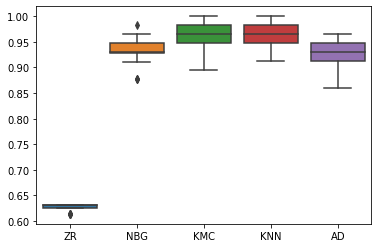

In [104]:
list_estimators = ['ZR', 'NBG', 'KMC','KNN', 'AD']
table_scores = pd.DataFrame(columns=list_estimators)
for i in range(len(list_estimators)):
    table_scores[list_estimators[i]] = list_scores[i]
_ = sns.boxplot(data=table_scores)